# Benchmark: PXD024043 - Proteins

In this notebook, we will explore the latent representation of the data generated by protVI.

Let's start with the imports.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(42)
scvi.settings.seed = 42

Global seed set to 42


Let's load the data.

In [2]:
adata = sc.read("../../../data/processed/brunner2022.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 434 × 2501
    obs: 'date', 'unknown1', 'n_cells', 'species', 'unknown2', 'unknown3', 'unknown4', 'position', 'replicate', 'file_index', 'condition', 'coarse_condition', 'cell_cycle_stage'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description'
    layers: 'raw'

## PROTVI

### Training

Let's now train the model.

In [26]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [27]:
PROTVI.setup_anndata(adata) #, batch_key="coarse_condition")

model = PROTVI(adata, log_variational=False,  n_hidden=32)
#model.view_anndata_setup()

Let's train the model.

In [28]:
model.train(max_epochs=4000, plan_kwargs={"mechanism_weight": 1, "lr": 5e-3, "min_kl_weight": 6, "max_kl_weight": 6}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 6, "max_kl_weight": 6})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 4000/4000: 100%|██████████| 4000/4000 [12:35<00:00,  5.43it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.02e+3]

`Trainer.fit` stopped: `max_epochs=4000` reached.


Epoch 4000/4000: 100%|██████████| 4000/4000 [12:35<00:00,  5.29it/s, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.02e+3]


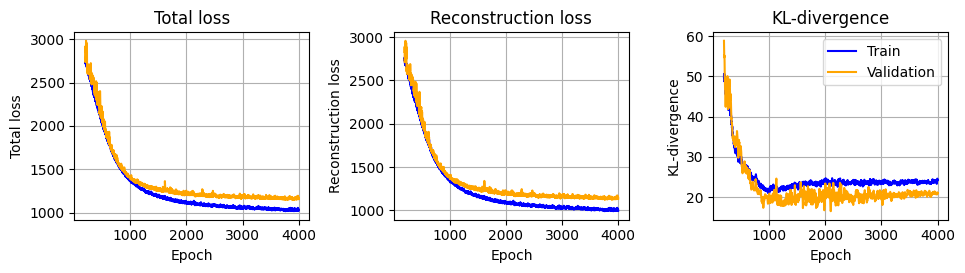

In [29]:
pl.plot_loss(model.history, epoch_start=200)

In [31]:
model.save("brunner2022_selection")

In [32]:
model = PROTVI.load("brunner2022_selection", adata)

INFO     File brunner2022_selection/model.pt already downloaded                                                    


### Evaluation on training set

In [57]:
x_est, p_est, x_var = model.impute()

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

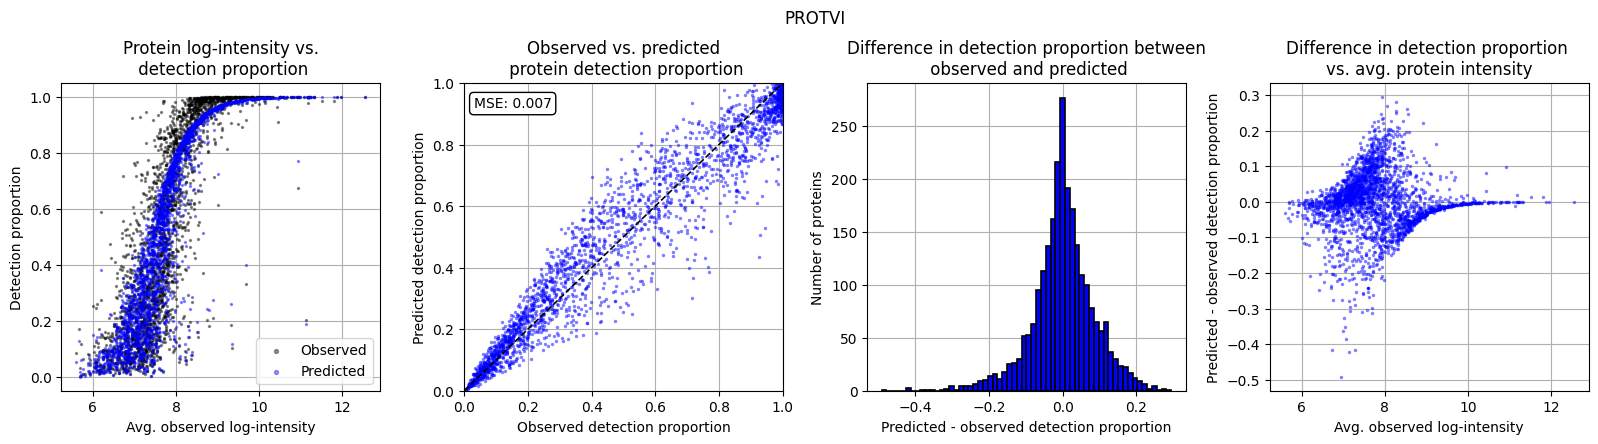

In [34]:
pl.plot_protein_detection_proportion_panel(x_data, p_est)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

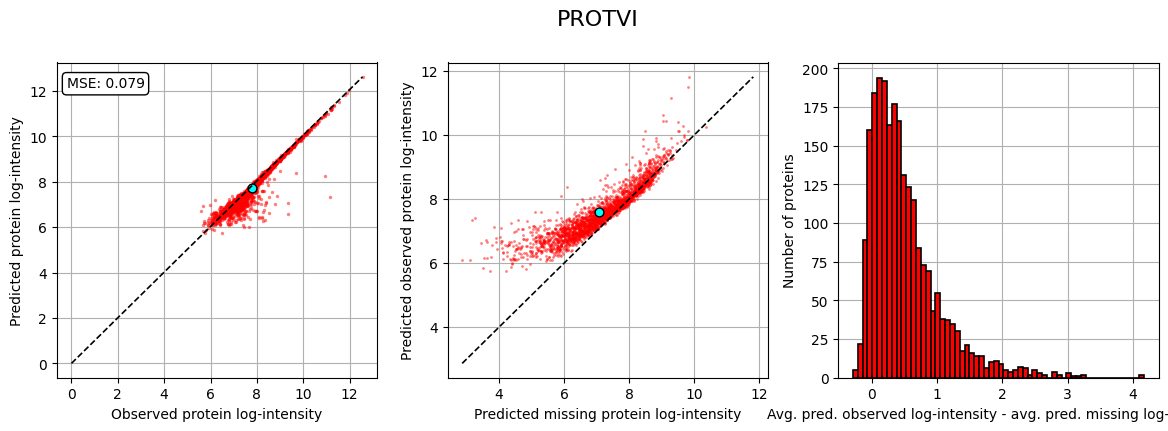

In [36]:
pl.plot_protein_intensity_panel(x_data, x_est)

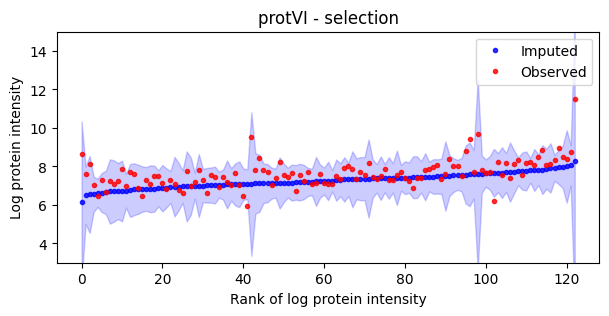

In [74]:
protein_missingness = utils.get_missingness_per_protein(adata, layer="raw")

n = 1000
idx = np.argsort(protein_missingness)[::-1][:n]

fig, ax = plt.subplots(1, 1, figsize=(7, 3))

idx_cell = 0

x_est_obs_sub = x_est_obs[idx_cell, idx]
x_var_sub = x_var[idx_cell, idx]
x_data_sub = x_data[idx_cell, idx]

order = np.argsort(x_est_obs_sub)

ax.set_ylim(3, 15)

ax.plot(np.arange(idx.shape[0]), x_est_obs_sub[order], "o", markersize=3, alpha=0.8, color="blue", label="Imputed")
ax.fill_between(np.arange(idx.shape[0]), x_est_obs_sub[order] - 2 * np.sqrt(x_var_sub[order]), x_est_obs_sub[order] + 2 * np.sqrt(x_var_sub[order]), alpha=0.2, color="blue")
ax.plot(np.arange(idx.shape[0]), x_data_sub[order], "o", markersize=3, alpha=0.8, color="red", label="Observed")
ax.set_xlabel("Rank of log protein intensity")
ax.set_ylabel("Log protein intensity")
ax.set_title("protVI - selection")
ax.legend()

Let's look at the latent space.

In [38]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

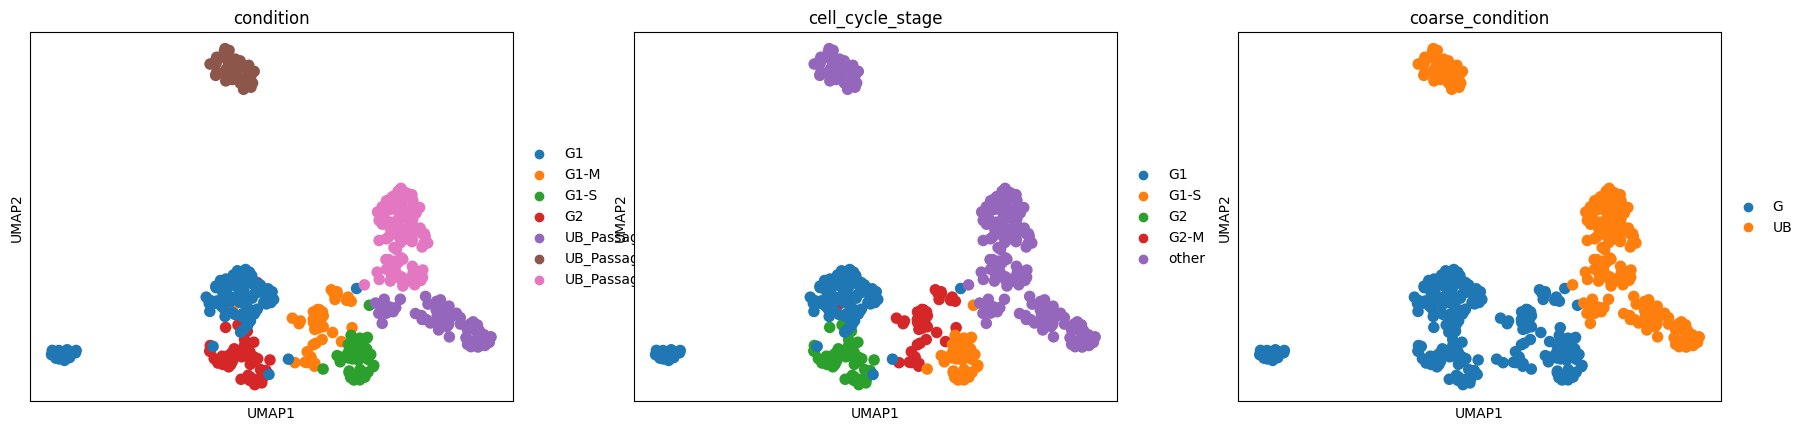

In [39]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
    vmin="p01", vmax="p99",
)

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

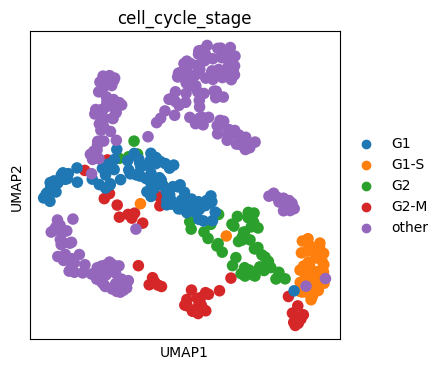

In [45]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(
        adata, 
        color=["cell_cycle_stage"], 
        vmin="p01", vmax="p99",
        ncols=3,
        wspace=0.3,
    )

Let's see how much of the variance can be explained by PCA.

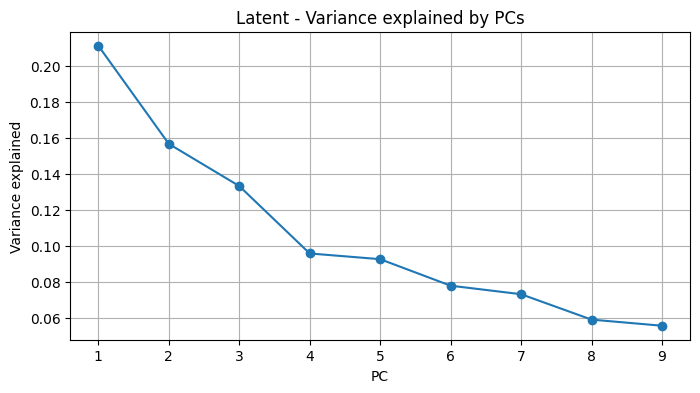

In [46]:
latent_pcs, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, latent_pcs.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_pcs.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title("Latent - Variance explained by PCs")
ax.grid(True)
ax.set_axisbelow(True)

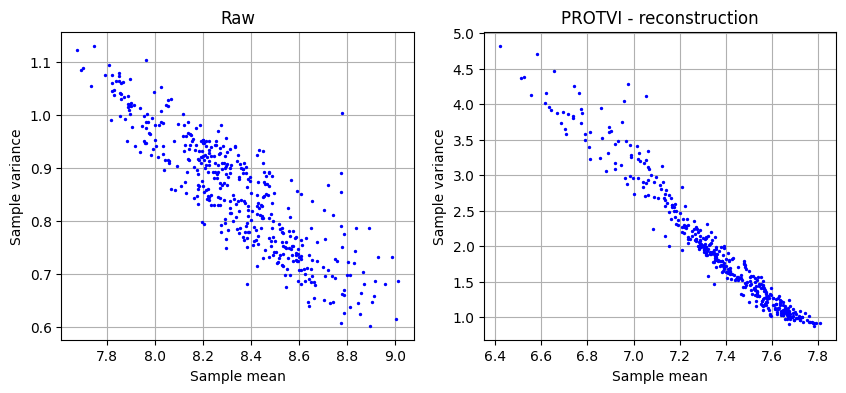

In [49]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["raw"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [50]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [51]:
r_adata = utils.prepare_anndata_for_R(adata)

In [52]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw")
dpcfit <- dpc(X)

In [53]:
protdp_result = robjects.r("dpcfit")

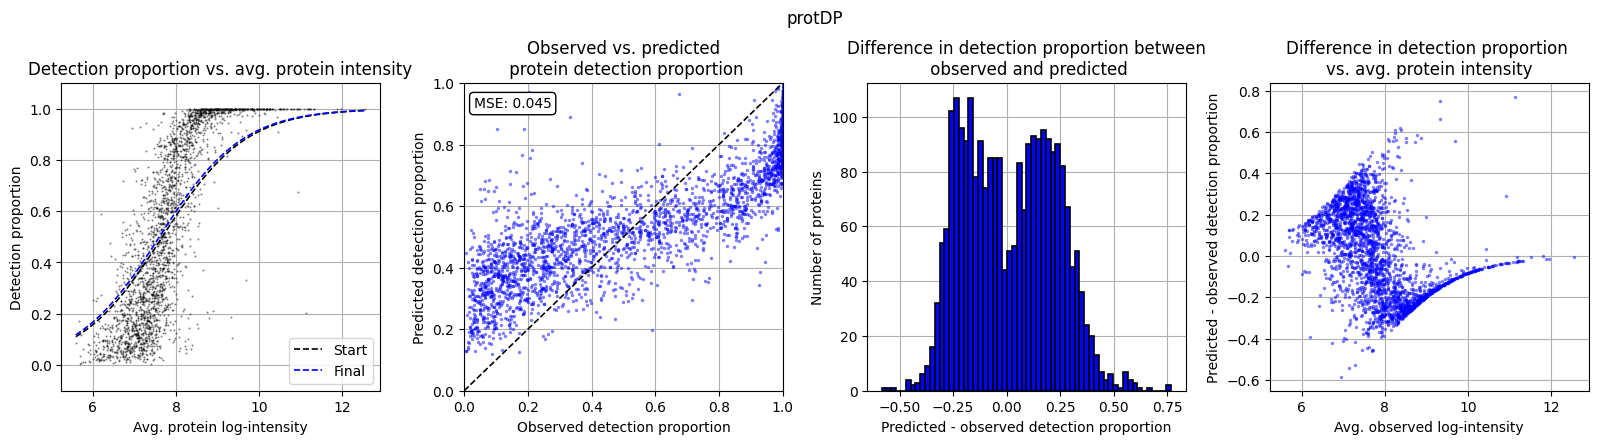

In [54]:
pl.plot_protein_detection_proportion_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_36921/1935104467.py:8: RuntimeWarning: Mean of empty slice
  x_est_miss_protein = np.nanmean(x_est_miss, axis=0)


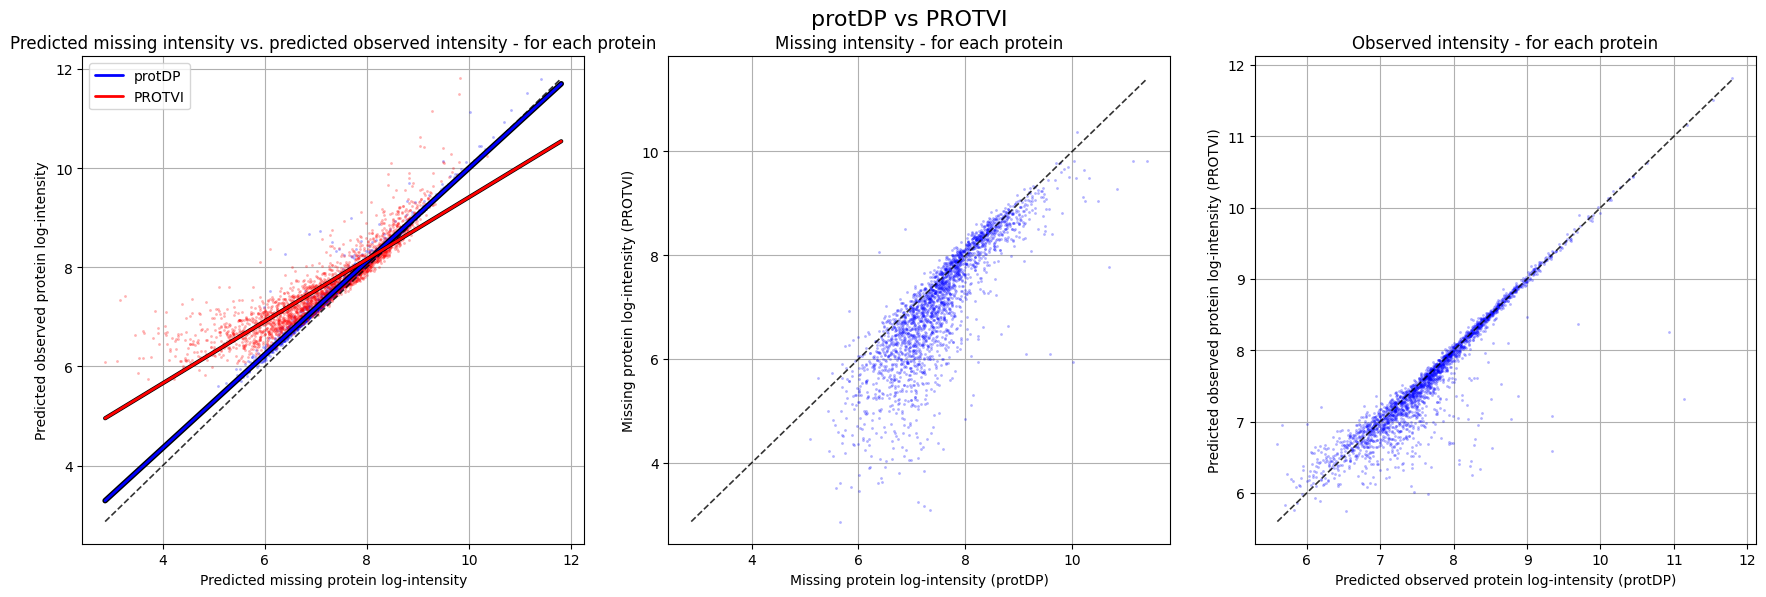

In [55]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

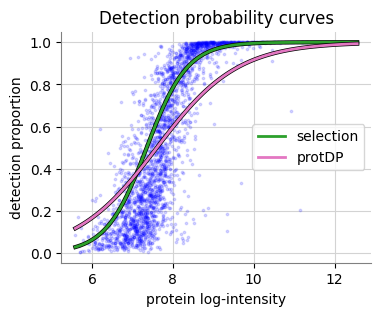

In [75]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_data, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_data), axis=0)
    p_est_protein = p_est.mean(axis=0)

    fig, ax = plt.subplots(figsize=(4, 3), ncols=1)

    all_models = ["baseline", "conjunction", "selection", "hybrid", "downshift local", "5-nn", "protDP"]
    color_palette = sns.color_palette('tab10', len(all_models))
    color_map = { model: color_palette[i] for i, model in enumerate(all_models) }

    pl.scatter_protein_detection_proportion_and_intensity(x_data, ax=ax)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", linewidth=3)
    ax.plot(xs, ys, color=color_map["selection"], label="selection", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", linewidth=3)
    ax.plot(xs, ys, color=color_map["protDP"], label="protDP", linewidth=2)
    ax.legend()

    ax.set_title("Detection probability curves")

    plt.savefig("brunner_detection_probability_curves.png", dpi=200, bbox_inches="tight")